In [6]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from typing import TypedDict, List, Literal, Dict

class State(TypedDict):
    messages: List[HumanMessage | AIMessage]
    user_input: str
    service: str
    service_docs: str
    bot_docs: str
    answer: str
    bot_id: str
    user_id: str
    tool_result: str

def init_chat_model():
    return ChatOpenAI(temperature=0.7, model="gpt-4")

# Сервисный роутер
async def service_router(state: State, config: RunnableConfig) -> State:

    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a service router. Determine which service the user's request is related to: 'accounts', 'cards', or 'parking'."),
        ("human", "{user_input}")
    ])
    chain = prompt | init_chat_model() | StrOutputParser()
    service = await chain.ainvoke({"user_input": state["user_input"]})
    return {"service": service}

# Функции для работников (заглушки)
@tool
def transfer_money(amount: float, to_account: str) -> str:
    """_summary_

    Args:
        amount (float): _description_
        to_account (str): _description_

    Returns:
        str: _description_
    """
    return f"Button: Transfer {amount} to {to_account}"

@tool
def reissue_card() -> str:
    """_summary_

    Returns:
        str: _description_
    """
    return "Button: Reissue card"

@tool
def book_parking(hours: int) -> str:
    """_summary_

    Args:
        hours (int): _description_

    Returns:
        str: _description_
    """
    return f"Button: Book parking for {hours} hours"

@tool
def pay_parking(amount: float) -> str:
    """_summary_

    Args:
        amount (float): _description_

    Returns:
        str: _description_
    """
    return f"Button: Pay {amount} for parking"

# Создание подграфа для работника
def create_worker_subgraph(worker_name: str, worker_tools: List[tool]):
    async def load_service_docs(state: State, config: RunnableConfig) -> State:
        # Здесь должна быть логика загрузки документации для выбранного сервиса
        return {"service_docs": f"{worker_name} documentation placeholder"}

    async def load_bot_docs(state: State, config: RunnableConfig) -> State:
        # Здесь должна быть логика загрузки документации бота
        return {"bot_docs": f"{worker_name} bot documentation placeholder"}

    async def process_message(state: State, config: RunnableConfig) -> State:
        prompt = ChatPromptTemplate.from_messages([
            ("system", "You are a helpful banking assistant. Use the provided information to answer the user's question or call an appropriate tool."),
            ("human", "{user_input}"),
            ("system", "Service documentation: {service_docs}"),
            ("system", "Bot documentation: {bot_docs}")
        ])
        chain = prompt | init_chat_model().bind(tools=worker_tools)
        response = await chain.ainvoke({
            "user_input": state["user_input"],
            "service_docs": state["service_docs"],
            "bot_docs": state["bot_docs"]
        })
        return {"answer": response.content, "tool_calls": response.additional_kwargs.get("tool_calls", [])}

    subgraph = StateGraph(State)
    subgraph.add_node("load_service_docs", load_service_docs)
    subgraph.add_node("load_bot_docs", load_bot_docs)
    subgraph.add_node("process_message", process_message)
    subgraph.add_node("tools", ToolNode(worker_tools))

    subgraph.set_entry_point("load_service_docs")
    subgraph.add_edge("load_service_docs", "load_bot_docs")
    subgraph.add_edge("load_bot_docs", "process_message")

    def route_tool_or_end(state: State) -> Literal["tools", "__end__"]:
        return "tools" if state.get("tool_calls") else "end"

    subgraph.add_conditional_edges("process_message", route_tool_or_end)
    subgraph.add_edge("tools", END)

    return subgraph.compile()

# Создание подграфов для работников
accounts_subgraph = create_worker_subgraph("Accounts", [transfer_money])
cards_subgraph = create_worker_subgraph("Cards", [reissue_card])
parking_subgraph = create_worker_subgraph("Parking", [book_parking, pay_parking])

# Основной граф
main_graph = StateGraph(State)
main_graph.add_node("service_router", service_router)
main_graph.add_node("accounts", accounts_subgraph)
main_graph.add_node("cards", cards_subgraph)
main_graph.add_node("parking", parking_subgraph)

main_graph.set_entry_point("service_router")

def route_to_service(state: State) -> Literal["accounts", "cards", "parking"]:
    return state["service"]

main_graph.add_conditional_edges("service_router", route_to_service)
main_graph.add_edge("accounts", END)
main_graph.add_edge("cards", END)
main_graph.add_edge("parking", END)
graph_runtime = main_graph.compile()


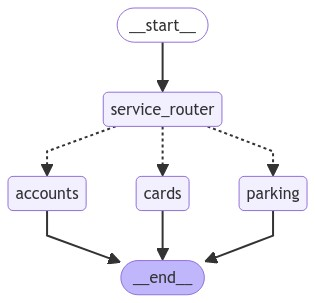

In [7]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph_runtime.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)
